## About

This notebook tried to reproduce interesting example described in the paper:

Hongzhou Lin, Stefanie Jegelka, ResNet with one-neuron hidden layers is a Universal Approximator, [arXiv:1806.10909](https://arxiv.org/abs/1806.10909) [cs.LG]

Can really ResNet _only with one neuron in each layer_ learn the example dataset?? (--> Partly confirmed)

In [1]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
np.warnings.filterwarnings('ignore')

### Using Scikit-learn Classifier Comparison Code

scikit-learn is always useful for quick try. Here I quote useful code from this:

http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [2]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb

def compare_classifiers(datasets, classifiers, names, size=(27, 9)):
    h = .02  # step size in the mesh

    figure = plt.figure(figsize=size)
    i = 1
    # iterate over datasets
    for ds_cnt, ds in enumerate(datasets):
        # preprocess dataset, split into training and test part
        X, y = ds
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=.4, random_state=42)

        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # just plot the dataset first
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        if ds_cnt == 0:
            ax.set_title("Input data")
        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
                   edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        i += 1

        # iterate over classifiers
        for name, clf in zip(names, classifiers):
            ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

            # Plot also the training points
            ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                       edgecolors='k')
            # and testing points
            ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                       edgecolors='k', alpha=0.6)

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            ax.set_xticks(())
            ax.set_yticks(())
            if ds_cnt == 0:
                ax.set_title(name)
            ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                    size=15, horizontalalignment='right')
            i += 1

    plt.tight_layout()
    plt.show()

### Using Keras

In [3]:
import keras
from keras.layers import Dense, Conv2D, SeparableConv2D, Convolution2D, AveragePooling2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Activation, Dropout, BatchNormalization, Flatten, Input
from keras.models import Model
from keras.optimizers import Adam

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


## 1. Training fully connected networks with width d = 2 per hidden layer

In [4]:
# Fully connected network definition

def model_dense(input_shape, num_hidden, num_width=10):
    X_input = Input(shape=input_shape)
    X = Dense(num_width)(X_input)
    for i in range(1, num_hidden):
        X = Dense(num_width, activation='relu')(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_input, outputs=X)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
    return model

def get_dense_fn(num_hidden, num_width=2):
    return model_dense(input_shape=[2], num_hidden=num_hidden, num_width=num_width)

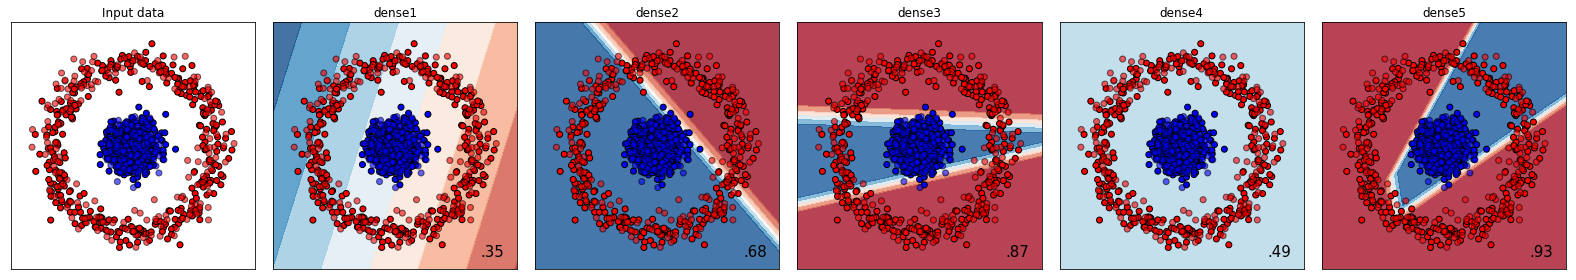

In [5]:
N = 5
VERBOSE=0

datasets = [make_circles(n_samples=1000, noise=0.1, factor=0.2, random_state=1),]
names = ['dense l=%d' % i for i in range(1, N + 1)]
classifiers = [
    KerasClassifier(build_fn=get_dense_fn, epochs=500, batch_size=5, verbose=VERBOSE, num_width=2, num_hidden=i)
        for i in range(1, N + 1)]
compare_classifiers(datasets, classifiers, names, size=(22, 4))

It reproduced with number of layers 3 and 5, but not with 1, 2 and 4.

Anyway it is confirmed that all of them cannot capture decision boundary.

## 2. Training ResNet with one neuron in the hidden layers

In [5]:
from keras.layers import Add

def resnet_block(input):
    init = input
    x = Dense(1, activation='relu')(init)
    x = Activation('relu')(x)
    #print(input.shape)
    x = Dense(int(input.shape[1]))(x)
    m = Add()([x, init])
    return m

def model_resnet(input_shape, num_hidden):
    X_input = Input(shape=input_shape)
    X = resnet_block(X_input)
    for i in range(1, num_hidden):
        X = resnet_block(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_input, outputs=X)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
    return model

def get_resnet_fn(num_hidden):
    return model_resnet(input_shape=[2], num_hidden=num_hidden)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 1)            3           input_6[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 1)            0           dense_21[0][0]                   
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 2)            4           activation_1[0][0]               
__________________________________________________________________________________________________
add_1 (Add

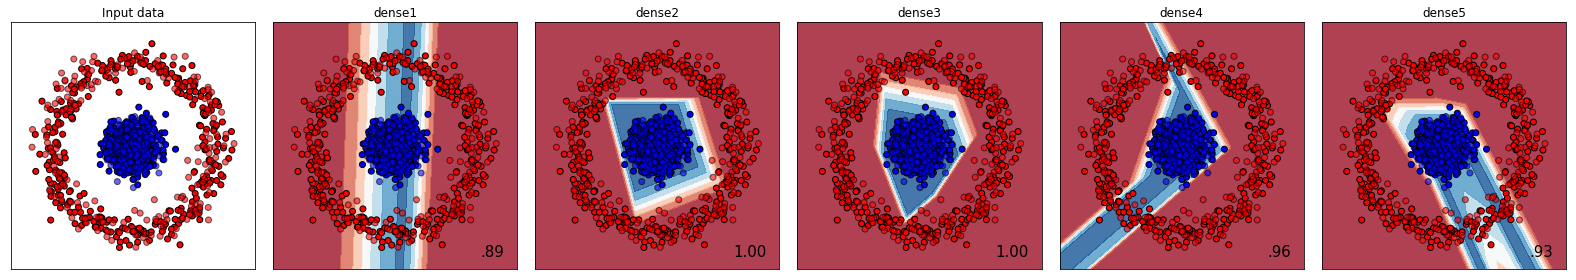

In [7]:
names = ['resnet l=%d' % i for i in range(1, N + 1)]
classifiers = [
    KerasClassifier(build_fn=get_resnet_fn, epochs=500, batch_size=5, verbose=VERBOSE, num_hidden=i)
        for i in range(1, N + 1)]
get_resnet_fn(4).summary()
compare_classifiers(datasets, classifiers, names, size=(22, 4))

It reproduced with number of layers 2 and 3, but not with others _this time_.

As far as I tried, _due to some reason like parameter is not good (not confirmed yet)_, it reproduced randomly. Sometimes it does, sometimes does not.

## 3. (Supplementary check) Fully connected network with width d = 10

This network with many neurons in each layer is supposed to learn preferable decision boundary, and it could.

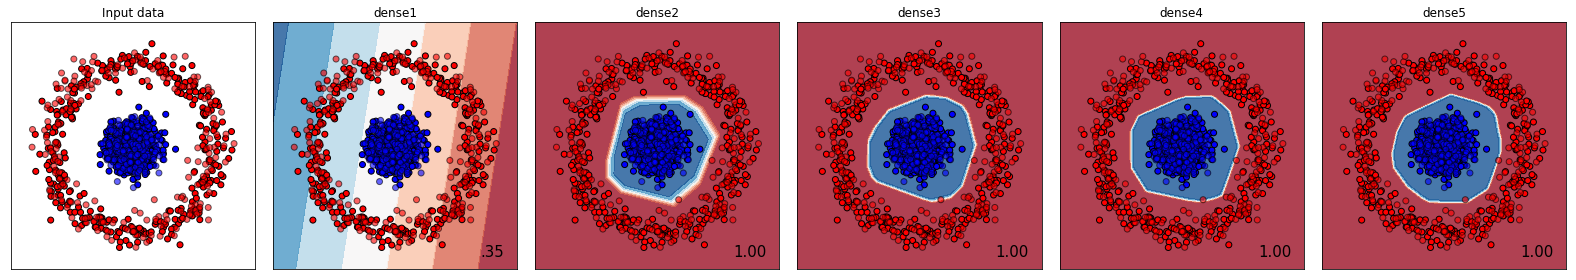

In [8]:
names = ['dense l=%d' % i for i in range(1, N + 1)]
classifiers = [
    KerasClassifier(build_fn=get_dense_fn, epochs=500, batch_size=5, verbose=VERBOSE, num_width=10, num_hidden=i)
        for i in range(1, N + 1)]
compare_classifiers(datasets, classifiers, names, size=(22, 4))

## 4. (Just for fun) Many basic traditional classifiers

Most of them are just scikit-learn example as is, I added XGB.

http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

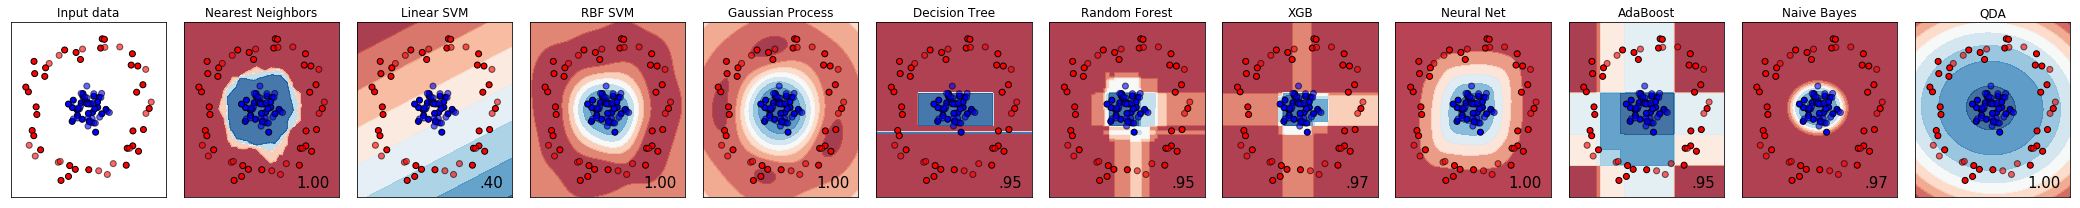

In [9]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "XGB", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=5),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                                               random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [#make_moons(noise=0.3, random_state=0),
            #make_circles(noise=0.2, factor=0.5, random_state=1),
            #linearly_separable,
            make_circles(noise=0.1, factor=0.2, random_state=1),
]

compare_classifiers(datasets, classifiers, names, size=(29, 3))

## X. (More fun part) What about other training samples

Tried datasets used in scikit-learn example as well.

http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [ ]:
datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable,
            make_circles(noise=0.1, factor=0.2, random_state=1),
]

names = ['dense d=2 l=%d' % i for i in range(1, N + 1)]
classifiers = [
    KerasClassifier(build_fn=get_dense_fn, epochs=500, batch_size=5, verbose=VERBOSE, num_width=2, num_hidden=i)
        for i in range(1, N + 1)]
compare_classifiers(datasets, classifiers, names, size=(22, 12))

In [ ]:
names = ['dense d=10 l=%d' % i for i in range(1, N + 1)]
classifiers = [
    KerasClassifier(build_fn=get_dense_fn, epochs=500, batch_size=5, verbose=VERBOSE, num_width=10, num_hidden=i)
        for i in range(1, N + 1)]
compare_classifiers(datasets, classifiers, names, size=(22, 12))

In [ ]:
names = ['resnet l=%d' % i for i in range(1, N + 1)]
classifiers = [
    KerasClassifier(build_fn=get_resnet_fn, epochs=500, batch_size=5, verbose=VERBOSE, num_hidden=i)
        for i in range(1, N + 1)]
compare_classifiers(datasets, classifiers, names, size=(22,  12))

## Network configurations

In [10]:
[get_dense_fn(i).summary() for i in range(1, N + 1)]
[get_resnet_fn(i).summary() for i in range(1, N + 1)]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_85 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_87 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_88 (Dense)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
dense_120 (Dense)               (None, 1)            3           input_25[0][0]                   
__________________________________________________________________________________________________
activation_26 (Activation)      (None, 1)            0           dense_120[0][0]                  
__________________________________________________________________________________________________
dense_121 (Dense)               (None, 2)            4           activation_26[0][0]              
__________________________________________________________________________________________________
add_26 (Ad

[None, None, None, None, None]